# Neural Color Transfer (Multi-Reference Style Transfer)

## Library

In [1]:
#Append 'src' direc to import modules from notebooks directory#
##################################################
#import os,sys
#src_dir=os.path.join(os.getcwd(),os.pardir)
#sys.path.append(src_dir)
#################################################

In [2]:
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import matplotlib as plt
import numpy as np
import torch

from PIL import Image
from skimage import color
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from torch import nn, optim
from torchvision import models, transforms

## Input Source & Reference Image

In [4]:
USE_CUDA = True  # or False if you don't have CUDA
FEATURE_IDS = [1, 6, 11, 20, 29]
LEFT_SHIFT = (1, 2, 0)
RIGHT_SHIFT = (2, 0, 1)

imgS_path = './image/3_Source1.jpg'
imgR_path = './image/3_Reference.jpg'

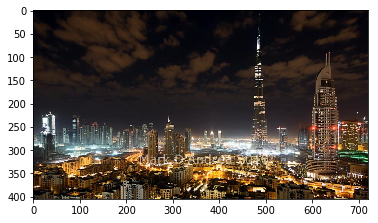

In [5]:
# Checking
origS = Image.open(imgS_path).convert("RGB")
imshow(origS)

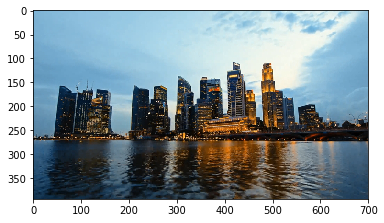

In [6]:
# Checking
origR = Image.open(imgR_path).convert("RGB")
imshow(origR)

## Image Loader

In [7]:
def image_loader(img_path, flip=False):
    img = Image.open(img_path).convert("RGB")
    if flip:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)

    data_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
    img_tensor = data_transforms(img)
    img_tensor = img_tensor.unsqueeze(0)
    return img_tensor


def tsshow(img_tensor):
    img_np = img_tensor.squeeze().numpy().transpose(LEFT_SHIFT)
    imshow(img_np)  # , interpolation = 'nearest')

In [8]:
imgS = image_loader(imgS_path, flip=False)
imgR = image_loader(imgR_path, flip=False)

imgS_np = imgS.squeeze().numpy().transpose(LEFT_SHIFT)
imgR_np = imgR.squeeze().numpy().transpose(LEFT_SHIFT)

In [9]:
# Checking
print(imgS.size())  # (1, 3, SHeight, SWidth)
print(imgR.size())  # (1, 3, RHeight, RWidth)
print(imgS.dtype, imgR.dtype, "\n")  # torch.float32

print(imgS_np.shape)  # (SHeight, SWidth, 3)
print(imgR_np.shape, "\n")  # (RHeight, RWidth, 3)

# Verifying normalization
print("Original S's mean:", np.asarray(origS).mean(axis=(0, 1)))
print("Original S's std:", np.asarray(origS).std(axis=(0, 1)))
print("Normalized S's mean:", imgS_np.mean(axis=(0, 1)))
print("Normalized S's std:", imgS_np.std(axis=(0, 1)), "\n")

print("Original R's mean:", np.asarray(origR).mean(axis=(0, 1)))
print("Original R's std:", np.asarray(origR).std(axis=(0, 1)))
print("Normalized R's mean:", imgR_np.mean(axis=(0, 1)))
print("Normalized R's std:", imgR_np.std(axis=(0, 1)))

torch.Size([1, 3, 405, 720])
torch.Size([1, 3, 394, 700])
torch.float32 torch.float32 

(405, 720, 3)
(394, 700, 3) 

Original S's mean: [61.62190329 50.21784294 41.66634088]
Original S's std: [57.8738523  52.01588416 45.43425297]
Normalized S's mean: [-1.0626439 -1.15655   -1.0782337]
Normalized S's std: [0.99107546 0.9106422  0.79188246] 

Original R's mean: [109.97153009 127.81088107 135.57476432]
Original R's std: [67.65980285 78.28225721 87.38713418]
Normalized R's mean: [-0.23466858  0.20187134  0.5585145 ]
Normalized R's std: [1.1586574 1.3704876 1.5230874]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


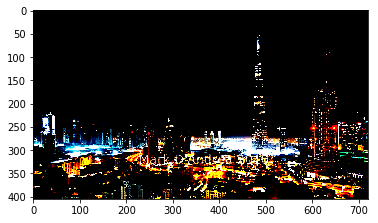

In [10]:
# Checking
tsshow(imgS)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


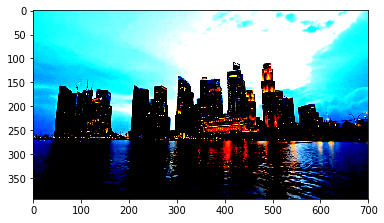

In [11]:
# Checking
tsshow(imgR)

## Process
From S_6 = S_(L+1) to S_1(Final Result)

Feature Domain
    > FeatureExtractor
    > PatchMatch
    > BDS Voting

Image Domain
    > Resolution equal
    > Local Color Transfer

## Feature Extractor

In [12]:
class FeatureExtractor(nn.Sequential):
    def __init__(self):
        super(FeatureExtractor, self).__init__()

    def add_layer(self, name, layer):
        self.add_module(name, layer)

    def forward(self, x, feature_id):
        for idx, module in enumerate(self._modules):
            x = self._modules[module](x)
            if idx == feature_id:
                return x

In [13]:
vgg_temp = models.vgg19(pretrained=True).features
model = FeatureExtractor()  # The new Feature Extractor module network

conv_counter = 1
relu_counter = 1
block_counter = 1

for i, layer in enumerate(list(vgg_temp)):
    if isinstance(layer, nn.Conv2d):
        name = "conv_" + str(block_counter) + "_" + str(conv_counter)
        conv_counter += 1
        model.add_layer(name, layer)

    if isinstance(layer, nn.ReLU):
        name = "relu_" + str(block_counter) + "_" + str(relu_counter)
        relu_counter += 1
        model.add_layer(name, layer)

    if isinstance(layer, nn.MaxPool2d):
        name = "pool_" + str(block_counter) 
        relu_counter = conv_counter = 1
        block_counter += 1
        model.add_layer(name, nn.AvgPool2d(2, 2))  # Is nn.AvgPool2d(2, 2) better than nn.MaxPool2d?

if USE_CUDA:
    model.cuda('cuda:3')

In [14]:
# Checking
print(model)
print([list(model._modules)[idx] for idx in FEATURE_IDS])

FeatureExtractor(
  (conv_1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1_1): ReLU(inplace)
  (conv_1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1_2): ReLU(inplace)
  (pool_1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv_2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2_1): ReLU(inplace)
  (conv_2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2_2): ReLU(inplace)
  (pool_2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv_3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3_1): ReLU(inplace)
  (conv_3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3_2): ReLU(inplace)
  (conv_3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3_3): ReLU(inplace)
  (conv_3_4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3_4): ReLU(i

In [15]:
def get_feature(img_tensor, feature_id):
    if USE_CUDA:
        img_tensor = img_tensor.cuda('cuda:3')

    feature_tensor = model(img_tensor, feature_id)
    feature = feature_tensor.data.squeeze().cpu().numpy().transpose(LEFT_SHIFT)
    return feature


def normalize(feature):
    return feature / np.linalg.norm(feature, ord=2, axis=2, keepdims=True)

In [16]:
feat5S = get_feature(imgS, FEATURE_IDS[4])
feat5R = get_feature(imgR, FEATURE_IDS[4])
feat5S_norm = normalize(feat5S)
feat5R_norm = normalize(feat5R)

In [17]:
# Checking
print(feat5S.shape)
print(feat5R.shape)

(25, 45, 512)
(24, 43, 512)


In [ ]:
# (IN PROGRESS)
# EXPERIMENTAL
class DeepDream:
    """
        Produces an image that minimizes the loss of a convolution
        operation for a specific layer and filter
    """
    def __init__(self, model, selected_layer, selected_filter, im_path):
        self.model = model
        self.selected_layer = selected_layer
        self.selected_filter = selected_filter
        self.conv_output = 0
        self.image = image_loader(im_path, flip=False)

        if USE_CUDA:
            self.model.cuda('cuda:3')
            self.image = self.image.cuda('cuda:3')

        self.image.requires_grad_()
        # Hook the layers to get result of the convolution
        self.hook_layer()

    def hook_layer(self):
        def hook_function(module, grad_in, grad_out):
            # Get the conv output of the selected filter (from selected layer)
            self.conv_output = grad_out[0, self.selected_filter]

        # Hook the selected layer
        self.model[self.selected_layer].register_forward_hook(hook_function)

    def dream(self):
        # Define optimizer for the image
        # Earlier layers need higher learning rates to visualize whereas lower layers need less
        optimizer = optim.SGD([self.image], lr=12, weight_decay=1e-4)
        # optimizer = optim.Adam([self.image], lr=0.1, weight_decay=1e-6)
        for i in range(1, 251):
            optimizer.zero_grad()
            # Assign image to a variable to move forward in the model
            x = self.image
            for index, layer in enumerate(self.model):
                # Forward
                x = layer(x)
                # Only need to forward until the selected layer is reached
                if index == self.selected_layer:
                    break
            # Loss function is the mean of the output of the selected layer/filter
            # We try to minimize the mean of the output of that specific filter
            loss = -torch.mean(self.conv_output)
            if i % 10 == 0:
                print("Iteration:", str(i) + "/250", "Loss:", "{0:.2f}".format(loss.data.cpu().numpy()))
            # Backward
            loss.backward()
            # Update image
            optimizer.step()

In [ ]:
# (IN PROGRESS)
# EXPERIMENTAL
cnn_layer = FEATURE_IDS[4]
filter_pos = 94
dd = DeepDream(vgg_temp, cnn_layer, filter_pos, imgS_path)
# This operation can also be done without Pytorch hooks
# See layer visualisation for the implementation without hooks
dd.dream()

dd_image_np = dd.image.data.squeeze().cpu().numpy().transpose(LEFT_SHIFT)
imshow(dd_image_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406])

## PatchMatch (Radius를 추가할까?)

In [18]:
class PatchMatch: 
    def __init__(self, a, b, patch_size=3):
        self.a = a
        self.b = b
        self.ah = a.shape[0]
        self.aw = a.shape[1]
        self.bh = b.shape[0]
        self.bw = b.shape[1]
        self.patch_size = patch_size

        self.nnf = np.zeros((self.ah, self.aw, 2)).astype(np.int)  # The NNF
        self.nnd = np.zeros((self.ah, self.aw))  # The NNF distance map
        self.init_nnf()

    def init_nnf(self):
        for ay in range(self.ah):
            for ax in range(self.aw):
                by = np.random.randint(self.bh)
                bx = np.random.randint(self.bw)
                self.nnf[ay, ax] = [by, bx]
                self.nnd[ay, ax] = self.calc_dist(ay, ax, by, bx)

    def calc_dist(self, ay, ax, by, bx):
        """
            Measure distance between 2 patches across all channels
            ay : y coordinate of a patch in a
            ax : x coordinate of a patch in a
            by : y coordinate of a patch in b
            bx : x coordinate of a patch in b
        """
        dy0 = dx0 = self.patch_size // 2
        dy1 = dx1 = self.patch_size // 2 + 1
        dy0 = min(ay, by, dy0)
        dy1 = min(self.ah - ay, self.bh - by, dy1)
        dx0 = min(ax, bx, dx0)
        dx1 = min(self.aw - ax, self.bw - bx, dx1)

        dist = np.sum(np.square(self.a[ay - dy0:ay + dy1, ax - dx0:ax + dx1] - self.b[by - dy0:by + dy1, bx - dx0:bx + dx1]))
        dist /= ((dy0 + dy1) * (dx0 + dx1))
        return dist

    def improve_guess(self, ay, ax, by, bx, ybest, xbest, dbest):
        d = self.calc_dist(ay, ax, by, bx)
        if d < dbest:
            ybest, xbest, dbest = by, bx, d
        return ybest, xbest, dbest

    def improve_nnf(self, total_iter=5):
        for iter in range(total_iter):
            if iter % 2:
                ystart, yend, ychange = self.ah - 1, -1, -1
                xstart, xend, xchange = self.aw - 1, -1, -1
            else:
                ystart, yend, ychange = 0, self.ah, 1
                xstart, xend, xchange = 0, self.aw, 1

            for ay in range(ystart, yend, ychange):
                for ax in range(xstart, xend, xchange):
                    ybest, xbest = self.nnf[ay, ax]
                    dbest = self.nnd[ay, ax]

                    # Propagation
                    if 0 <= (ay - ychange) < self.ah:
                        yp, xp = self.nnf[ay - ychange, ax]
                        yp += ychange
                        if 0 <= yp < self.bh:
                            ybest, xbest, dbest = self.improve_guess(ay, ax, yp, xp, ybest, xbest, dbest)
                    if 0 <= (ax - xchange) < self.aw:
                        yp, xp = self.nnf[ay, ax - xchange]
                        xp += xchange
                        if 0 <= xp < self.bw:
                            ybest, xbest, dbest = self.improve_guess(ay, ax, yp, xp, ybest, xbest, dbest)

                    # Random search
                    rand_d = max(self.bh, self.bw)
                    while rand_d >= 1:
                        ymin, ymax = max(ybest - rand_d, 0), min(ybest + rand_d, self.bh)
                        xmin, xmax = max(xbest - rand_d, 0), min(xbest + rand_d, self.bw)
                        yp = np.random.randint(ymin, ymax)
                        xp = np.random.randint(xmin, xmax)
                        ybest, xbest, dbest = self.improve_guess(ay, ax, yp, xp, ybest, xbest, dbest)
                        rand_d = rand_d // 2

                    self.nnf[ay, ax] = [ybest, xbest]
                    self.nnd[ay, ax] = dbest
            print("iteration:", str(iter + 1) + "/" + str(total_iter))

    def solve(self):
        self.improve_nnf(total_iter=5)

In [19]:
map5SR = PatchMatch(feat5S_norm, feat5R_norm)  # S -> R
map5RS = PatchMatch(feat5R_norm, feat5S_norm)  # R -> S
map5SR.solve()
print()
map5RS.solve()

iteration: 1/5
iteration: 2/5
iteration: 3/5
iteration: 4/5
iteration: 5/5

iteration: 1/5
iteration: 2/5
iteration: 3/5
iteration: 4/5
iteration: 5/5


In [20]:
# Checking
print(map5SR.nnf.shape)
print(map5SR.nnd.shape, "\n")

print(map5RS.nnf.shape)
print(map5RS.nnd.shape)

(25, 45, 2)
(25, 45) 

(24, 43, 2)
(24, 43)


## Image Resizing

In [21]:
def image_to_tensor(img, img_transforms=None):
    if img_transforms is None:
        img_transforms = list()
    data_transforms = transforms.Compose(img_transforms + [
        transforms.ToTensor(),
    ])
    img_tensor = data_transforms(img)
    return img_tensor


def resize_img(img, size):
    return image_to_tensor(img, [transforms.Resize(size)])

In [22]:
imgS_resized = resize_img(origS, feat5S.shape[:2])
imgR_resized = resize_img(origR, feat5R.shape[:2])

In [23]:
# Checking
print(imgS_resized.size())
print(imgR_resized.size())

torch.Size([3, 25, 45])
torch.Size([3, 24, 43])


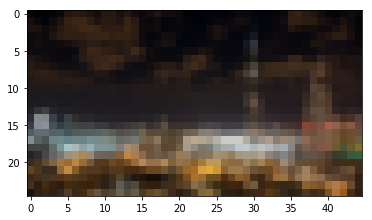

In [24]:
# Checking
tsshow(imgS_resized)

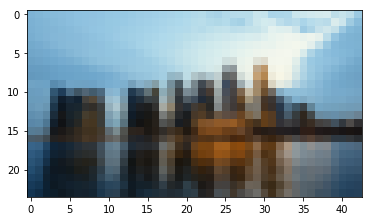

In [25]:
# Checking
tsshow(imgR_resized)

## BDS Voting (Reconstruct)

In [26]:
def bds_vote(ref, nnf_sr, nnf_rs, patch_size=3):
    """
    Reconstructs an image or feature map by bidirectionaly
    similarity voting
    """

    src_height = nnf_sr.shape[0]
    src_width = nnf_sr.shape[1]
    ref_height = nnf_rs.shape[0]
    ref_width = nnf_rs.shape[1]
    channel = ref.shape[0]

    guide = np.zeros((channel, src_height, src_width))
    weight = np.zeros((src_height, src_width))
    ws = 1 / (src_height * src_width)
    wr = 1 / (ref_height * ref_width)

    # coherence
    # The S->R forward NNF enforces coherence
    for sy in range(src_height):
        for sx in range(src_width):
            ry, rx = nnf_sr[sy, sx]

            dy0 = dx0 = patch_size // 2
            dy1 = dx1 = patch_size // 2 + 1
            dy0 = min(sy, ry, dy0)
            dy1 = min(src_height - sy, ref_height - ry, dy1)
            dx0 = min(sx, rx, dx0)
            dx1 = min(src_width - sx, ref_width - rx, dx1)

            guide[:, sy - dy0:sy + dy1, sx - dx0:sx + dx1] += ws * ref[:, ry - dy0:ry + dy1, rx - dx0:rx + dx1]
            weight[sy - dy0:sy + dy1, sx - dx0:sx + dx1] += ws

    # completeness
    # The R->S backward NNF enforces completeness
    for ry in range(ref_height):
        for rx in range(ref_width):
            sy, sx = nnf_rs[ry, rx]

            dy0 = dx0 = patch_size // 2
            dy1 = dx1 = patch_size // 2 + 1
            dy0 = min(sy, ry, dy0)
            dy1 = min(src_height - sy, ref_height - ry, dy1)
            dx0 = min(sx, rx, dx0)
            dx1 = min(src_width - sx, ref_width - rx, dx1)

            guide[:, sy - dy0:sy + dy1, sx - dx0:sx + dx1] += wr * ref[:, ry - dy0:ry + dy1, rx - dx0:rx + dx1]
            weight[sy - dy0:sy + dy1, sx - dx0:sx + dx1] += wr

    weight[weight == 0] = 1
    guide /= weight
    return guide

In [27]:
imgG = bds_vote(imgR_resized, map5SR.nnf, map5RS.nnf)
feat5G = bds_vote(feat5R.transpose(RIGHT_SHIFT), map5SR.nnf, map5RS.nnf).transpose(LEFT_SHIFT)
feat5G_norm = normalize(feat5G)

In [28]:
# Checking
print(imgG.shape, "==", imgR_resized.size()[0], map5SR.nnf.shape[:2])
print(feat5G.shape, "==", map5SR.nnf.shape[:2], feat5R.shape[2])

(3, 25, 45) == 3 (25, 45)
(25, 45, 512) == (25, 45) 512


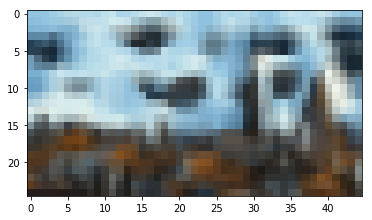

In [29]:
# Checking
imshow(imgG.transpose(LEFT_SHIFT))

## Affine Transfrom

In [30]:
kmeans = KMeans(n_clusters=10, n_jobs=1).fit(feat5S.reshape(-1, feat5S.shape[2]))
kmeans_labels = kmeans.labels_.reshape(feat5S.shape[:2])

In [31]:
labS = color.rgb2lab(imgS_resized.numpy().transpose(LEFT_SHIFT))
labG = color.rgb2lab(imgG.transpose(LEFT_SHIFT))

In [32]:
# Checking
print(labS.shape)
print(labG.shape)

(25, 45, 3)
(25, 45, 3)


In [33]:
class LocalColorTransfer:
    def __init__(self, s, g, featS_norm, featG_norm, kmeans_ratio=1, patch_size=3):
        self.source = torch.from_numpy(s).float()
        self.guide = torch.from_numpy(g).float()
        self.featS_norm = torch.from_numpy(featS_norm).float()
        self.featG_norm = torch.from_numpy(featG_norm).float()
        self.height = s.shape[0]
        self.width = s.shape[1]
        self.channel = s.shape[2]
        self.patch_size = patch_size

        self.paramA = torch.zeros(s.shape)
        self.paramB = torch.zeros(s.shape)

        self.kmeans_labels = np.zeros(s.shape[:2]).astype(np.int32)
        self.kmeans_ratio = kmeans_ratio

        if USE_CUDA:
            self.source = self.source.cuda('cuda:3')
            self.guide = self.guide.cuda('cuda:3')
            self.featS_norm = self.featS_norm.cuda('cuda:3')
            self.featG_norm = self.featG_norm.cuda('cuda:3')
            self.paramA = self.paramA.cuda('cuda:3')
            self.paramB = self.paramB.cuda('cuda:3')
        self.init_params()

    def init_params(self):
        """
            Initialize a and b from source and guidance using mean and std
        """
        eps = 0.002
        for y in range(self.height):
            for x in range(self.width):
                dy0 = dx0 = self.patch_size // 2
                dy1 = dx1 = self.patch_size // 2 + 1
                dy0 = min(y, dy0)
                dy1 = min(self.height - y, dy1)
                dx0 = min(x, dx0)
                dx1 = min(self.width - x, dx1)

                patchS = self.source[y - dy0:y + dy1, x - dx0:x + dx1].reshape(-1, self.channel)
                patchG = self.guide[y - dy0:y + dy1, x - dx0:x + dx1].reshape(-1, self.channel)
                self.paramA[y, x] = patchG.std(0) / (patchS.std(0) + eps)
                self.paramB[y, x] = patchG.mean(0) - self.paramA[y, x] * patchS.mean(0)

                y_adj = min(y // self.kmeans_ratio, kmeans_labels.shape[0] - 1)
                x_adj = min(x // self.kmeans_ratio, kmeans_labels.shape[1] - 1)
                self.kmeans_labels[y, x] = kmeans_labels[y_adj, x_adj]
        self.paramA.requires_grad_()
        self.paramB.requires_grad_()

    def visualize(self):
        transfered = self.paramA * self.source + self.paramB
        imshow(color.lab2rgb(transfered.data.cpu().numpy().astype(np.float64)))

    def loss_d(self):
        error = torch.pow(self.featS_norm - self.featG_norm, 2)
        transfered = self.paramA * self.source + self.paramB
        term1 = torch.sum(1 - error / error.norm(2, 2, keepdim=True), 2)
        term2 = torch.pow(transfered - self.guide, 2).sum(2)
        loss_d = torch.mean(term1 * term2)

        return loss_d

    def loss_l(self):
        loss_l = 0
        for y in range(self.height):
            for x in range(self.width):
                dy0 = dx0 = self.patch_size // 2
                dy1 = dx1 = self.patch_size // 2 + 1
                dy0 = min(y, dy0)
                dy1 = min(self.height - y, dy1)
                dx0 = min(x, dx0)
                dx1 = min(self.width - x, dx1)

                patchS = self.source[y - dy0:y + dy1, x - dx0:x + dx1]  # (3, 4) ~ (3, 6) ~ (3, 9(3 * 3))
                patchA = self.paramA[y - dy0:y + dy1, x - dx0:x + dx1]
                patchB = self.paramB[y - dy0:y + dy1, x - dx0:x + dx1]
                allS = self.source[y, x].reshape(1, 1, self.channel)
                allA = self.paramA[y, x].reshape(1, 1, self.channel)
                allB = self.paramA[y, x].reshape(1, 1, self.channel)

                patchSD = torch.norm(allS - patchS, 2, 2).exp()  # (PatchHeight, PatchWidth)
                wgt = patchSD / patchSD.sum()
                # Getting norm term
                term1 = torch.pow(allA - patchA, 2).sum(2)
                term2 = torch.pow(allB - patchB, 2).sum(2)
                term3 = term1 + term2
                loss_l += torch.sum(wgt * term3) / (self.height * self.width)

        return loss_l

        """
            if y == 0:
                if x == 0:
                    allA = patchA[0 ,0].view(3, 1, 1)  # left up corner
                elif x == self.width - 1:
                    allA = patchA[0, 1].view(3, 1, 1)  # right up corner
                else:
                    allA = patchA[0, 1].view(3, 1, 1)
            elif y == self.height - 1:
                if x == 0:
                    allA = patchA[1, 0].view(3, 1, 1)  # left down corner
                elif x == self.width - 1:
                    allA = patchA[1, 1].view(3, 1, 1)  # right down corner
                else:
                    allA = patchA[1, 1].view(3, 1, 1)
            else:
                if x == 0:
                    allA = patchA[1, 0].view(3, 1, 1)  # left middle
                elif x == self.width - 1:
                    allA = patchA[1, 1].view(3, 1, 1)  # right middle
                else:
                    allA = patchA[1, 1].view(3, 1, 1)  # middle

            멍청한 내 자신의 노가다;
        """

    def loss_nl(self):
        index_map = np.zeros((2, self.height, self.width)).astype(np.int32)
        index_map[0] = np.arange(self.height)[:, np.newaxis] + np.zeros(self.width).astype(np.int32)
        index_map[1] = np.zeros(self.height).astype(np.int32)[:, np.newaxis] + np.arange(self.width)

        loss_nl = 0
        for i in range(10):
            index_map_cluster = index_map[:, self.kmeans_labels == i]
            source_cluster = self.source[index_map_cluster[0], index_map_cluster[1]]
            paramA_cluster = self.paramA[index_map_cluster[0], index_map_cluster[1]]
            paramB_cluster = self.paramB[index_map_cluster[0], index_map_cluster[1]]

            nbrs = NearestNeighbors(n_neighbors=9, n_jobs=1).fit(source_cluster)
            indices = nbrs.kneighbors(source_cluster, return_distance=False)

            for index in indices:
                patchS = source_cluster[index[1:]]
                patchA = paramA_cluster[index[1:]]
                patchB = paramB_cluster[index[1:]]
                allS = source_cluster[index[0]].reshape(1, self.channel)

                patchT = patchA * patchS + patchB
                allT = torch.reshape(paramA_cluster[index[0]] * source_cluster[index[0]] + paramB_cluster[index[0]], (1, self.channel))

                patchSD = torch.norm(allS - patchS, 2, 1).exp()
                wgt = patchSD / patchSD.sum()
                term1 = torch.pow(allT - patchT, 2).sum(1)
                loss_nl += torch.sum(wgt * term1) / (self.height * self.width)

        return loss_nl

    def train(self, total_iter=250):
        optimizer = optim.Adam([self.paramA, self.paramB], lr=0.1, weight_decay=0)
        hyper_l = 0.005
        hyper_nl = 0.5
        for iter in range(total_iter):
            optimizer.zero_grad()

            loss_d = self.loss_d()
            loss_l = self.loss_l()
            loss_nl = self.loss_nl()
            loss = loss_d + hyper_l * loss_l + hyper_nl * loss_nl

            if (iter + 1) % 10 == 0:
                print("Iteration:", str(iter + 1) + "/" + str(total_iter), "Loss:", "{0:.4f}".format(loss.data.cpu().numpy()))
            loss.backward()
            optimizer.step()

In [34]:
lct = LocalColorTransfer(labS, labG, feat5S_norm, feat5G_norm, kmeans_ratio=1)

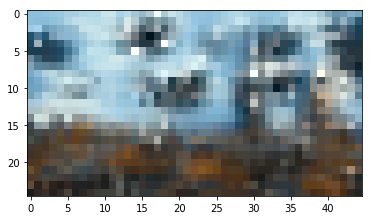

In [35]:
lct.visualize()

Iteration: 10/250 Loss: 21528.7285
Iteration: 20/250 Loss: 9708.8223
Iteration: 30/250 Loss: 5359.4414
Iteration: 40/250 Loss: 3182.8574
Iteration: 50/250 Loss: 1963.1627
Iteration: 60/250 Loss: 1312.2238
Iteration: 70/250 Loss: 911.7287
Iteration: 80/250 Loss: 671.6141
Iteration: 90/250 Loss: 521.5829
Iteration: 100/250 Loss: 428.5609
Iteration: 110/250 Loss: 370.5212
Iteration: 120/250 Loss: 334.5037
Iteration: 130/250 Loss: 312.2420
Iteration: 140/250 Loss: 298.5546
Iteration: 150/250 Loss: 290.1510
Iteration: 160/250 Loss: 284.9930
Iteration: 170/250 Loss: 281.8154
Iteration: 180/250 Loss: 279.8478
Iteration: 190/250 Loss: 278.6217
Iteration: 200/250 Loss: 277.8522
Iteration: 210/250 Loss: 277.3669
Iteration: 220/250 Loss: 277.0592
Iteration: 230/250 Loss: 276.8639
Iteration: 240/250 Loss: 276.7396
Iteration: 250/250 Loss: 276.6604


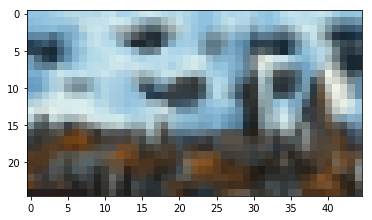

In [36]:
lct.train()
lct.visualize()

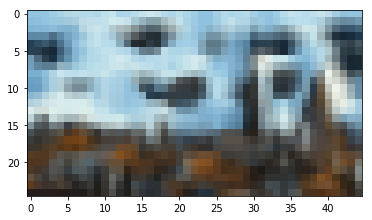

In [37]:
# Comparing
imshow(imgG.transpose(LEFT_SHIFT))

## WLS Filter

In [38]:
from guided_filter_pytorch.guided_filter import FastGuidedFilter
labOrigS = torch.from_numpy(color.rgb2lab(np.array(origS)).transpose(RIGHT_SHIFT)).float()
a_upsampled = FastGuidedFilter(1, eps=1e-08)(lct.source.permute(RIGHT_SHIFT).unsqueeze(0).cpu(),
                                             lct.paramA.permute(RIGHT_SHIFT).unsqueeze(0).cpu(),
                                             labOrigS.unsqueeze(0)).squeeze()
b_upsampled = FastGuidedFilter(1, eps=1e-08)(lct.source.permute(RIGHT_SHIFT).unsqueeze(0).cpu(),
                                             lct.paramB.permute(RIGHT_SHIFT).unsqueeze(0).cpu(),
                                             labOrigS.unsqueeze(0)).squeeze()

/home/seunghwan/anaconda3/envs/graduation/lib/python3.6/site-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/seunghwan/anaconda3/envs/graduation/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


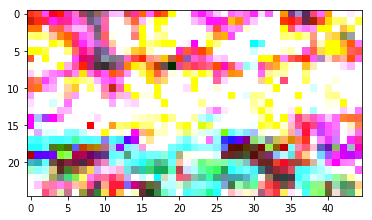

In [39]:
tsshow(lct.paramA.data.permute(RIGHT_SHIFT).cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


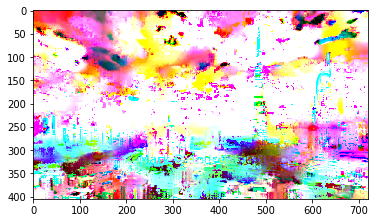

In [40]:
tsshow(a_upsampled.data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


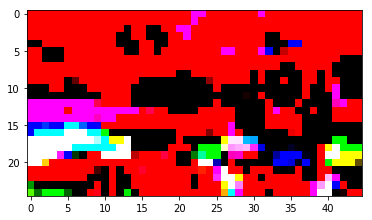

In [41]:
tsshow(lct.paramB.data.permute(RIGHT_SHIFT).cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


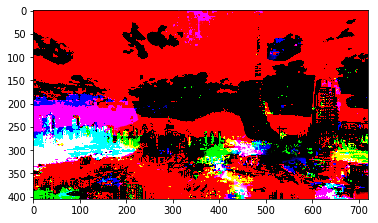

In [42]:
tsshow(b_upsampled.data)

/home/seunghwan/anaconda3/envs/graduation/lib/python3.6/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 8790 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


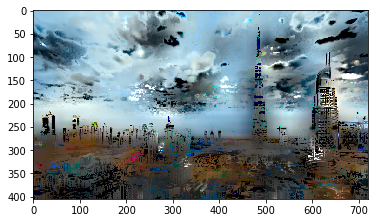

In [43]:
img5S = a_upsampled * labOrigS + b_upsampled
img5S = color.lab2rgb(img5S.data.numpy().transpose(LEFT_SHIFT).astype(np.float64))
imshow(img5S)

In [ ]:
img5S = torch.from_numpy(img5S.transpose(RIGHT_SHIFT)).float()
transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img5S)
img5S = img5S.unsqueeze(0)

In [ ]:
feat4S = get_feature(img5S, FEATURE_IDS[3])
feat4R = get_feature(imgR, FEATURE_IDS[3])
feat4S_norm = normalize(feat4S)
feat4R_norm = normalize(feat4R)

map4SR = PatchMatch(feat4S_norm, feat4R_norm) #S -> R
map4RS = PatchMatch(feat4R_norm, feat4S_norm) #R -> S
map4SR.solve()
print()
map4RS.solve()

imgS_resized = resize_img(origS, feat4S.shape[:2])
imgR_resized = resize_img(origR, feat4R.shape[:2])

imgG = bds_vote(imgR_resized, map4SR.nnf, map4RS.nnf)
feat4G = bds_vote(feat4R.transpose(RIGHT_SHIFT), map4SR.nnf, map4RS.nnf).transpose(LEFT_SHIFT)
feat4G_norm = normalize(feat4G)

labS = color.rgb2lab(imgS_resized.numpy().transpose(LEFT_SHIFT))
labG = color.rgb2lab(imgG.transpose(LEFT_SHIFT))

lct = LocalColorTransfer(labS, labG, feat4S_norm, feat4G_norm, kmeans_ratio=2)
lct.train()

a_upsampled = FastGuidedFilter(1, eps=1e-08)(lct.source.permute(RIGHT_SHIFT).unsqueeze(0).cpu(),
                                             lct.paramA.permute(RIGHT_SHIFT).unsqueeze(0).cpu(),
                                             labOrigS.unsqueeze(0)).squeeze()
b_upsampled = FastGuidedFilter(1, eps=1e-08)(lct.source.permute(RIGHT_SHIFT).unsqueeze(0).cpu(),
                                             lct.paramB.permute(RIGHT_SHIFT).unsqueeze(0).cpu(),
                                             labOrigS.unsqueeze(0)).squeeze()

img4S = a_upsampled * labOrigS + b_upsampled
img4S = color.lab2rgb(img4S.data.numpy().transpose(LEFT_SHIFT))
imshow(img4S)

In [ ]:
img4S = torch.from_numpy(img4S.transpose(RIGHT_SHIFT)).float()
transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img4S)
img4S = img4S.unsqueeze(0)

In [ ]:
feat3S = get_feature(img4S, FEATURE_IDS[2])
feat3R = get_feature(imgR, FEATURE_IDS[2])
feat3S_norm = normalize(feat3S)
feat3R_norm = normalize(feat3R)

map3SR = PatchMatch(feat3S_norm, feat3R_norm) #S -> R
map3RS = PatchMatch(feat3R_norm, feat3S_norm) #R -> S
map3SR.solve()
print()
map3RS.solve()

imgS_resized = resize_img(origS, feat3S.shape[:2])
imgR_resized = resize_img(origR, feat3R.shape[:2])

imgG = bds_vote(imgR_resized, map3SR.nnf, map3RS.nnf)
feat3G = bds_vote(feat3R.transpose(RIGHT_SHIFT), map3SR.nnf, map3RS.nnf).transpose(LEFT_SHIFT)
feat3G_norm = normalize(feat3G)

labS = color.rgb2lab(imgS_resized.numpy().transpose(LEFT_SHIFT))
labG = color.rgb2lab(imgG.transpose(LEFT_SHIFT))

lct = LocalColorTransfer(labS, labG, feat3S_norm, feat3G_norm, kmeans_ratio=4)
lct.train()

a_upsampled = FastGuidedFilter(1, eps=1e-08)(lct.source.permute(RIGHT_SHIFT).unsqueeze(0).cpu(),
                                             lct.paramA.permute(RIGHT_SHIFT).unsqueeze(0).cpu(),
                                             labOrigS.unsqueeze(0)).squeeze()
b_upsampled = FastGuidedFilter(1, eps=1e-08)(lct.source.permute(RIGHT_SHIFT).unsqueeze(0).cpu(),
                                             lct.paramB.permute(RIGHT_SHIFT).unsqueeze(0).cpu(),
                                             labOrigS.unsqueeze(0)).squeeze()

img3S = a_upsampled * labOrigS + b_upsampled
img3S = color.lab2rgb(img3S.data.numpy().transpose(LEFT_SHIFT))
imshow(img3S)

In [ ]:
img3S = torch.from_numpy(img3S.transpose(RIGHT_SHIFT)).float()
transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img3S)
img3S = img3S.unsqueeze(0)

In [ ]:
feat2S = get_feature(img3S, FEATURE_IDS[1])
feat2R = get_feature(imgR, FEATURE_IDS[1])
feat2S_norm = normalize(feat2S)
feat2R_norm = normalize(feat2R)

map2SR = PatchMatch(feat2S_norm, feat2R_norm) #S -> R
map2RS = PatchMatch(feat2R_norm, feat2S_norm) #R -> S
map2SR.solve()
print()
map2RS.solve()

imgS_resized = resize_img(origS, feat2S.shape[:2])
imgR_resized = resize_img(origR, feat2R.shape[:2])

imgG = bds_vote(imgR_resized, map2SR.nnf, map2RS.nnf)
feat2G = bds_vote(feat2R.transpose(RIGHT_SHIFT), map2SR.nnf, map2RS.nnf).transpose(LEFT_SHIFT)
feat2G_norm = normalize(feat2G)

labS = color.rgb2lab(imgS_resized.numpy().transpose(LEFT_SHIFT))
labG = color.rgb2lab(imgG.transpose(LEFT_SHIFT))

lct = LocalColorTransfer(labS, labG, feat2S_norm, feat2G_norm, kmeans_ratio=8)
lct.train()

a_upsampled = FastGuidedFilter(1, eps=1e-08)(lct.source.permute(RIGHT_SHIFT).unsqueeze(0).cpu(),
                                             lct.paramA.permute(RIGHT_SHIFT).unsqueeze(0).cpu(),
                                             labOrigS.unsqueeze(0)).squeeze()
b_upsampled = FastGuidedFilter(1, eps=1e-08)(lct.source.permute(RIGHT_SHIFT).unsqueeze(0).cpu(),
                                             lct.paramB.permute(RIGHT_SHIFT).unsqueeze(0).cpu(),
                                             labOrigS.unsqueeze(0)).squeeze()

img2S = a_upsampled * labOrigS + b_upsampled
img2S = color.lab2rgb(img2S.data.numpy().transpose(LEFT_SHIFT))
imshow(img2S)

In [ ]:
img2S = torch.from_numpy(img2S.transpose(RIGHT_SHIFT)).float()
transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img2S)
img2S = img2S.unsqueeze(0)

In [ ]:
feat1S = get_feature(img2S, FEATURE_IDS[0])
feat1R = get_feature(imgR, FEATURE_IDS[0])
feat1S_norm = normalize(feat1S)
feat1R_norm = normalize(feat1R)

map1SR = PatchMatch(feat1S_norm, feat1R_norm) #S -> R
map1RS = PatchMatch(feat1R_norm, feat1S_norm) #R -> S
map1SR.solve()
print()
map1RS.solve()

imgS_resized = resize_img(origS, feat1S.shape[:2])
imgR_resized = resize_img(origR, feat1R.shape[:2])

imgG = bds_vote(imgR_resized, map1SR.nnf, map1RS.nnf)
feat1G = bds_vote(feat1R.transpose(RIGHT_SHIFT), map1SR.nnf, map1RS.nnf).transpose(LEFT_SHIFT)
feat1G_norm = normalize(feat1G)

labS = color.rgb2lab(imgS_resized.numpy().transpose(LEFT_SHIFT))
labG = color.rgb2lab(imgG.transpose(LEFT_SHIFT))

lct = LocalColorTransfer(labS, labG, feat1S_norm, feat1G_norm, kmeans_ratio=16)
lct.train()

a_upsampled = FastGuidedFilter(1, eps=1e-08)(lct.source.permute(RIGHT_SHIFT).unsqueeze(0).cpu(),
                                             lct.paramA.permute(RIGHT_SHIFT).unsqueeze(0).cpu(),
                                             labOrigS.unsqueeze(0)).squeeze()
b_upsampled = FastGuidedFilter(1, eps=1e-08)(lct.source.permute(RIGHT_SHIFT).unsqueeze(0).cpu(),
                                             lct.paramB.permute(RIGHT_SHIFT).unsqueeze(0).cpu(),
                                             labOrigS.unsqueeze(0)).squeeze()

img1S = a_upsampled * labOrigS + b_upsampled
img1S = color.lab2rgb(img1S.data.numpy().transpose(LEFT_SHIFT))
imshow(img1S)